In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install ninja 2>> install.log

In [2]:
%%bash
git clone -b main https://github.com/Robert-Gomez-DS/global-model-repr.git 

Cloning into 'global-model-repr'...


In [4]:
try: # set up path
    import google.colab, sys, torch
    sys.path.append('/content/tutorial_code')
    sys.path.append('./global-model-repr/') 
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")  
except:
    pass

In [8]:
import sys, scipy 
import skimage.morphology
sys.path.append('./global-model-repr/') 

In [9]:
import torch, os, matplotlib.pyplot as plt
from netdissect import nethook, imgviz, show, segmenter, renormalize, upsample, tally, pbar
from netdissect import setting

torch.backends.cudnn.benchmark = True
torch.set_grad_enabled(False) # not training anything!

100%|██████████| 499777515/499777515 [01:44<00:00, 4777164.44it/s]


Extracting datasets/places_val.zip to datasets



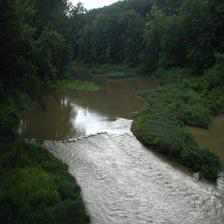

In [10]:
ds = setting.load_dataset('places', 'val')
iv = imgviz.ImageVisualizer(224, source=ds, percent_level=0.99)
show(iv.image(ds[0][0]))

In [11]:
model = setting.load_vgg16()
model = nethook.InstrumentedModel(model)

renorm = renormalize.renormalizer(source=ds, target='zc')
ivsmall = imgviz.ImageVisualizer((56, 56), source=ds, percent_level=0.99)


Downloading: "http://gandissect.csail.mit.edu/models/vgg16_places365-6e38b568.pth" to /home/silverwolf/.cache/torch/hub/checkpoints/vgg16_places365-6e38b568.pth
100%|██████████| 518M/518M [04:46<00:00, 1.90MB/s] 


In [12]:
print(model)

InstrumentedModel(
  (model): VGG(
    (features): Sequential(
      (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_1): ReLU(inplace=True)
      (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_2): ReLU(inplace=True)
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_1): ReLU(inplace=True)
      (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_2): ReLU(inplace=True)
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_1): ReLU(inplace=True)
      (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_2): ReLU(inplace=True)
      (conv3_3): Conv2d(256, 256, ker

310



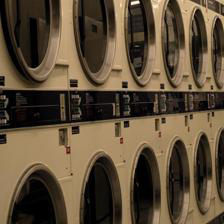
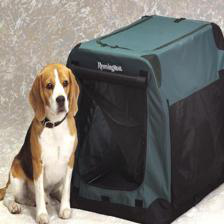
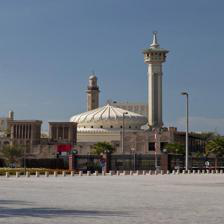
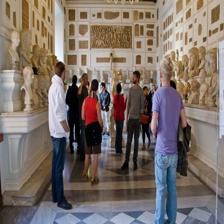
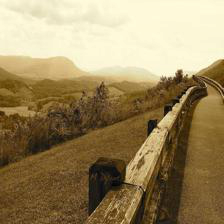
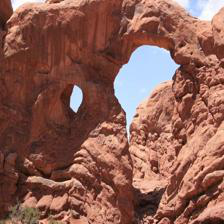
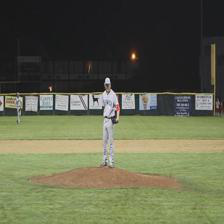
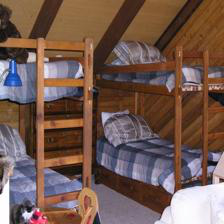
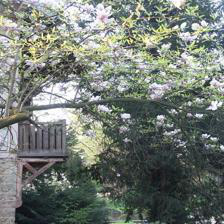
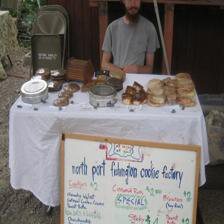
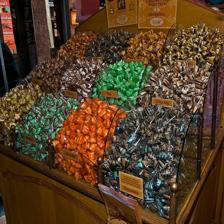
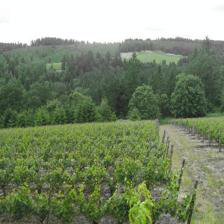

In [14]:
target_class = ds.classes.index('soccer_field')
print(target_class)
indexes = range(100, 112)
batch = torch.stack([ds[i][0] for i in indexes])
_, preds = model(batch).max(1)
show([[
    iv.image(batch[j]),
    'label: ' + ds.classes[ds[i][1]],
    'pred: ' + ds.classes[preds[j]],
    i,
] for j, i in enumerate(indexes)])

In [15]:
if False:
    correct = 0
    tested = 0
    for imagebatch, labelbatch in pbar(torch.utils.data.DataLoader(ds, batch_size=100)):
        modelpreds = model(imagebatch).max(1)[1]
        print(modelpreds.cpu(), labelbatch)
        correct += (modelpreds.cpu() == labelbatch).sum() # fixme
        tested += len(labelbatch)
    print('%d correct out of %d' % (correct, tested))


torch.Size([12, 512, 14, 14])



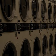
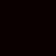
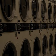
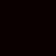
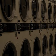
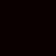
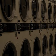
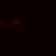
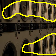
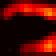
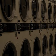
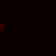
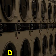
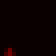
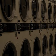
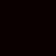
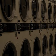
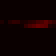
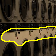
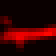
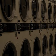
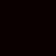
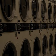
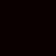
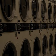
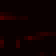
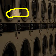
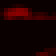
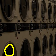
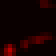
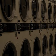
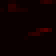
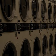
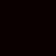
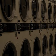
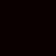
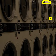
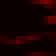
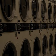
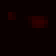
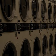
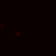
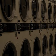
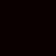
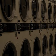
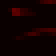
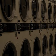
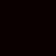


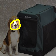
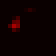
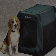
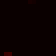
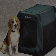
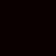
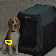
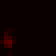
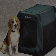
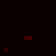
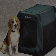
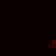
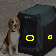
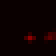
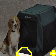
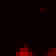
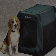
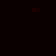
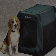
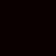
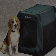
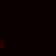
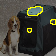
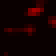
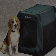
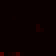
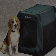
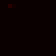
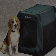
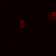
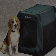
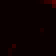
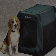
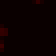
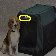
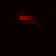
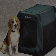
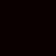
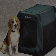
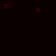
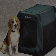
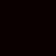
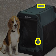
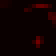
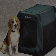
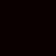
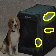
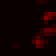


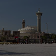
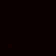
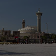
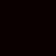
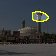
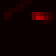
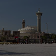
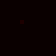
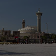
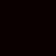
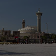
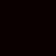
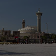
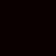
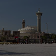
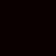
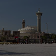
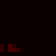
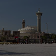
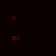
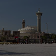
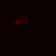
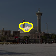
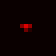
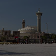
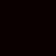
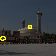
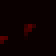
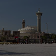
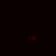
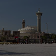
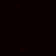
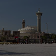
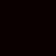
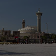
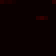
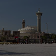
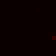
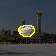
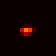
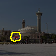
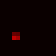
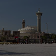
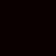
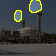
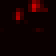
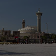
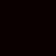


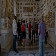
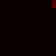
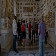
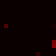
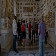
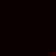
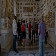
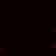
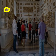
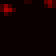
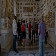
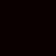
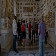
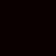
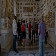
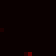
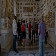
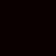
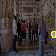
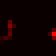
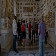
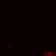
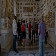
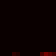
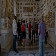
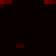
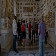
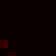
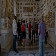
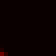
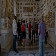
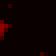
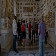
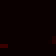
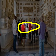
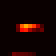
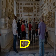
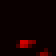
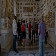
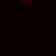
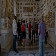
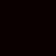
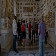
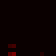
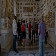
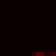
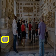
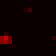


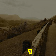
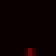
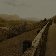
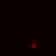
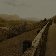
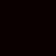
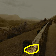
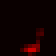
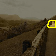
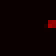
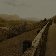
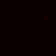
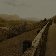
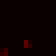
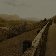
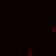
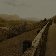
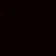
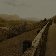
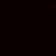
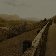
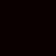
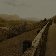
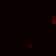
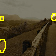
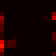
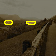
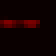
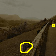
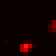
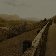
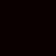
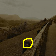
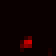
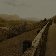
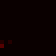
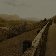
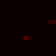
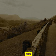
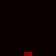
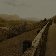
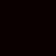
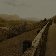
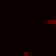
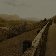
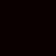
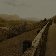
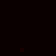


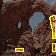
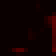
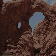
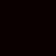
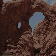
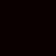
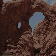
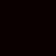
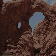
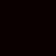
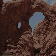
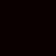
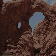
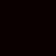
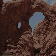
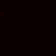
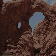
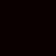
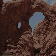
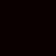
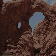
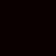
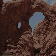
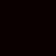
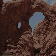
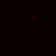
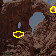
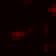
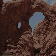
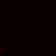
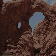
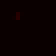
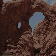
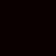
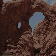
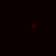
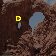
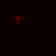
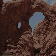
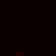
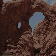
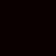
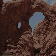
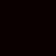
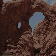
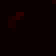
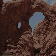
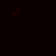


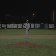
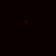
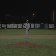
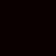
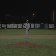
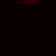
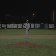
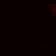
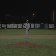
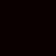
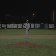
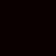
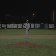
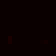
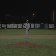
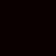
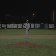
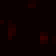
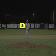
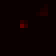
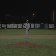
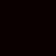
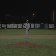
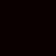
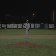
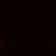
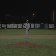
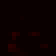
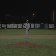
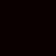
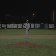
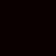
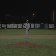
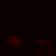
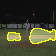
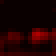
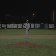
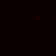
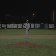
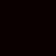
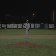
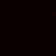
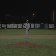
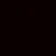
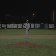
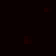
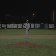
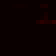

In [39]:
layername = 'features.conv5_3'
model.retain_layer(layername)
model(batch)
acts = model.retained_layer(layername).cpu()
print(acts.shape)
for i in range(7):
    show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'unit %d' % unitnum
    ]
    for unitnum in range(1,acts.shape[1]//10 -2,2)
    
    for imagenum in [i]
])

torch.Size([12, 512, 14, 14])



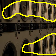
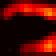
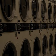
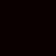
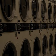
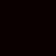
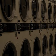
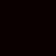


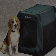
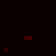
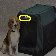
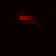
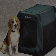
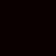
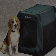
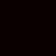


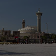
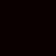
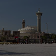
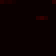
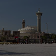
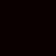
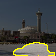
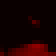


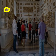
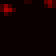
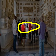
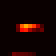
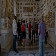
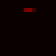
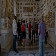
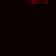


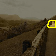
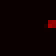
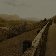
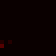
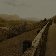
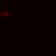
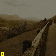
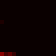


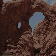
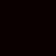
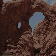
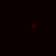
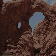
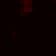
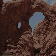
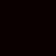


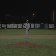
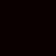
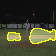
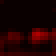
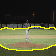
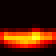
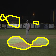
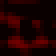

In [41]:
layername = 'features.conv5_3'
model.retain_layer(layername)
model(batch)
acts = model.retained_layer(layername).cpu()
print(acts.shape)
for i in range(7):
    show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'unit %d' % unitnum
    ]
    for unitnum in [9,35,298,315]
    
    for imagenum in [i]
])